In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import operator

In [2]:
Monday_path = 'data/pro-Monday-0.5v2.csv'
Monday = pd.read_csv(Monday_path ,sep=",")

Tuesday_path = 'data/pro-Tuesday-0.5v2.csv'
Tuesday = pd.read_csv(Tuesday_path ,sep=",")

Wednesday_path = 'data/pro-Wednesday-0.5v2.csv'
Wednesday = pd.read_csv(Wednesday_path ,sep=",")

Thursday_path = 'data/pro-Thursday-0.5v2.csv'
Thursday = pd.read_csv(Thursday_path ,sep=",")

Friday_path = 'data/pro-Friday-0.5v2.csv'
Friday = pd.read_csv(Friday_path ,sep=",")

In [7]:
def drop_attacks(data):

    drop_idx_master = []
    drop_idx = []
    for i in range(len(data)):
        if data.iloc[i]["Label"] == 'BENIGN':
            counter = 0
        elif data.iloc[i]["Label"] != 'BENIGN':
            counter += 1
            drop_idx.append(i)
            if data.iloc[i+1]["Label"] == 'BENIGN':
                amt_drop = int(0.95 * counter) # drop index of last 95%  of attack
                print ("{} initial amount: {}".format(data.iloc[i]["Label"], counter))
                print ("amt_dropped: " , amt_drop)
                drop_idx = drop_idx[-amt_drop:] # indexes list of one paticular attack to drop 
                drop_idx_master += drop_idx
                drop_idx = []

    data_reduced = data.drop(drop_idx_master)
    print ("drop completed!!")
    return data_reduced

In [4]:
def clean_data(data):
    
    data_label = data[["Label"]].copy()
    
    data_trimed = data.iloc[:, : len(data.columns) -1 ].copy() #exclude the 'Label' columns
    
    data_trimed = data_trimed.apply(pd.to_numeric,errors='coerce')
    data_trimed = data_trimed.fillna(data_trimed.mean())
    data_trimed = data_trimed.fillna(0.0)
    data_label.loc[data_label['Label'] == 'BENIGN' , "num_label"] = 0.0 #create new col "num_label" for numeric label
    data_label.loc[data_label['Label'] != 'BENIGN' , "num_label"] = 1.0
    
    data_final = pd.concat([data_label['num_label'], data_trimed], axis = 1)
    data_final = data_final.round(5)
    
    return data_final

In [17]:
def feature_select(meta_train, meta_valid, correlation_mark = 0.2):

    meta = pd.concat([meta_train, meta_valid], axis = 0)
    meta = clean_data(meta)

    meta_corr = meta.corr(method='pearson').iloc[:, [0]]
    meta_corr = meta_corr.fillna(0)
    features  = list(meta_corr.index)[:] 


    fig, ax = plt.subplots(figsize = (100,5))

    plt.xticks(range(len(features)),  features, rotation=90)
    plt.plot(list(meta_corr.iloc[:,0]))
    plt.xlabel('features', fontsize = 15)
    plt.ylabel('PCC Score', fontsize = 15)
    ax.axhline(y=correlation_mark, linestyle = ":", color = 'r')
    ax.axhline(y= 0.0, linestyle = ":", color = 'r')
    ax.axhline(y= -correlation_mark, linestyle = ":", color = 'r')
    ax.set_ylim(-0.5, 0.5)
    plt.show()


    ############## feature selection #################
    feature_select_dict = dict()
    features_select = []
    for i in range(len(list(meta_corr.iloc[:,0]))):
        if abs(list(meta_corr.iloc[:,0])[i]) >= correlation_mark:
            feature_select_dict[features[i]] = list(meta_corr.iloc[:,0])[i]
            features_select.append(features[i])

    print ('number of features: {}'.format(len(features_select)))
    print ('\n')
    print (' Selected features for model: ', features_select)
    meta_train = clean_data(meta_train)
    meta_valid = clean_data(meta_valid)

    meta_train_select = meta_train[features_select]
    meta_valid_select = meta_valid[features_select]

    return meta_train_select, meta_valid_select, features_select, feature_select_dict

In [6]:
Tuesday_reduced = drop_attacks(Tuesday)
Wednesday_reduced = drop_attacks(Wednesday)
Thursday_reduced = drop_attacks(Thursday)
Friday_reduced = drop_attacks(Friday)

Brute Force - FTP-Patator initial amount: 7200
('amt_dropped: ', 6840)
Brute Force - SSH-Patator initial amount: 7200
('amt_dropped: ', 6840)
drop completed!!
DoS slowloris initial amount: 2760
('amt_dropped: ', 2622)
DoS Slowhttptest initial amount: 2520
('amt_dropped: ', 2394)
DoS Hulk initial amount: 2040
('amt_dropped: ', 1938)
DoS GoldenEye initial amount: 1560
('amt_dropped: ', 1482)
Heartbleed Port 444 initial amount: 2400
('amt_dropped: ', 2280)
drop completed!!
Web Attack – Brute Force initial amount: 4800
('amt_dropped: ', 4560)
Web Attack – XSS initial amount: 2400
('amt_dropped: ', 2280)
Web Attack – Sql Injection initial amount: 240
('amt_dropped: ', 228)
Infiltration – Dropbox download - Meta exploit Win Vista initial amount: 240
('amt_dropped: ', 228)
Infiltration – Dropbox download - Meta exploit Win Vista initial amount: 240
('amt_dropped: ', 228)
Infiltration – Cool disk – MAC initial amount: 840
('amt_dropped: ', 798)
Infiltration – Dropbox download Win Vista initial

In [8]:
all_train_reduced = pd.concat([Monday, Tuesday_reduced, Wednesday_reduced], axis = 0)
all_valid_reduced = pd.concat([Thursday_reduced], axis = 0)
all_test_reduced = pd.concat([Friday_reduced], axis = 0)

In [9]:
print (all_train_reduced.groupby(['Label']).size().reset_index(name='counts'))
print (all_valid_reduced.groupby(['Label']).size().reset_index(name='counts'))
print (all_test_reduced.groupby(['Label']).size().reset_index(name='counts'))

                       Label  counts
0                     BENIGN  151114
1  Brute Force - FTP-Patator     360
2  Brute Force - SSH-Patator     360
3              DoS GoldenEye      78
4                   DoS Hulk     102
5           DoS Slowhttptest     126
6              DoS slowloris     138
7        Heartbleed Port 444     120
                                               Label  counts
0                                             BENIGN   44133
1                     Infiltration – Cool disk – MAC      42
2  Infiltration – Dropbox download - Meta exploit...      24
3          Infiltration – Dropbox download Win Vista     246
4                           Web Attack – Brute Force     240
5                         Web Attack – Sql Injection      12
6                                   Web Attack – XSS     120
                           Label  counts
0                         BENIGN   38960
1                    Botnet ARES     360
2                      DDoS LOIT     120
3  Port Scan – 

In [10]:
all_attack = 360+360+78+102+126+138+120+42+24+246+240+12+120+360+120+228+240.0
non_attack = 151114 + 44133 + 38960

print (all_attack / (all_attack + non_attack))
print (all_attack + non_attack)

0.0122974152655
237123.0


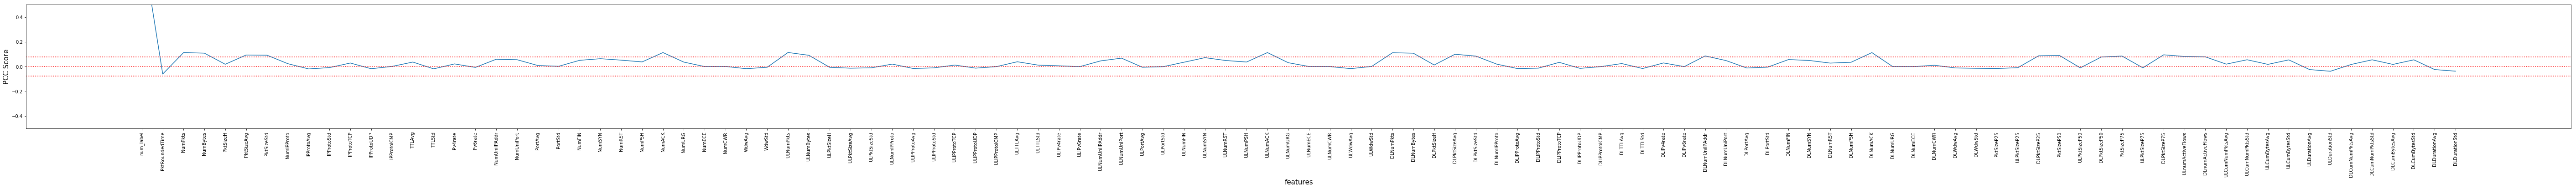

number of features: 21


(' Selected features for model: ', ['num_label', 'NumPkts', 'NumBytes', 'PktSizeAvg', 'PktSizeStd', 'NumACK', 'ULNumPkts', 'ULNumBytes', 'ULNumACK', 'DLNumPkts', 'DLNumBytes', 'DLPktSizeAvg', 'DLPktSizeStd', 'DLNumUniIPAddr', 'DLNumACK', 'DLPktSizeP25', 'PktSizeP50', 'PktSizeP75', 'DLPktSizeP75', 'ULnumActiveFlows', 'DLnumActiveFlows'])


In [18]:
##****** Features used for the 1% attack datasets

threshold = 0.078 #select features with PCC score greater or equals to threshold 
alltrainreduced_select, allvalidreduced_select, features_select, fea_dict = feature_select(all_train_reduced, all_valid_reduced, correlation_mark = threshold)
alltestreduced_select = clean_data(all_test_reduced)[features_select]

In [12]:
fea_dict_d = sorted(fea_dict.items(), key=operator.itemgetter(1))
fea_dict_d # Features and its PCC score sorted

[('DLnumActiveFlows', 0.07892003364393856),
 ('ULnumActiveFlows', 0.08188674565534114),
 ('DLPktSizeStd', 0.08478986254433747),
 ('PktSizeP75', 0.08535119489285395),
 ('DLNumUniIPAddr', 0.08632807431265764),
 ('DLPktSizeP25', 0.08735057836142998),
 ('PktSizeP50', 0.0899054780194791),
 ('ULNumBytes', 0.09155577951535573),
 ('PktSizeStd', 0.09241508733976554),
 ('PktSizeAvg', 0.09362235232567381),
 ('DLPktSizeP75', 0.09540451714506519),
 ('DLPktSizeAvg', 0.1000230843156442),
 ('DLNumBytes', 0.10838346994175366),
 ('NumBytes', 0.10869739178941368),
 ('DLNumPkts', 0.11203029645718339),
 ('DLNumACK', 0.11312596280863188),
 ('NumPkts', 0.11337043806302913),
 ('ULNumACK', 0.11344526008744207),
 ('NumACK', 0.11355449271994875),
 ('ULNumPkts', 0.11407960559635523),
 ('num_label', 1.0)]